## Brain MRI Segmentation with Unet | TensorFlow and Keras

In [ ]:
!pip install pandas==2.2.2 numpy==1.26.0 matplotlib opencv-python tqdm scikit-image scikit-learn tensorflow==2.17.0


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [ ]:
import os
import numpy as np
np.bool = bool

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import files
import os
import zipfile


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
rar_file_path = '/content/drive/MyDrive/kaggleMRI.rar'  # Update this path

In [ ]:
# Step 3: Create a directory to extract the contents
extracted_data_dir = '/content/data'
os.makedirs(extracted_data_dir, exist_ok=True)

In [ ]:
!pip install rarfile
!apt-get install unrar



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import rarfile

# Step 4: Extract the rar file
try:
    with rarfile.RarFile(rar_file_path, 'r') as rar_ref:
        rar_ref.extractall(extracted_data_dir)
    print("Dataset successfully extracted to:", extracted_data_dir)
except rarfile.RarCannotExec as e:
    print("Ensure the unrar utility is installed by running: !apt-get install unrar")
except Exception as e:
    print("An error occurred while extracting the rar file:", e)

Dataset successfully extracted to: /content/data


In [ ]:
# Setting size parameters of images
im_width = 256
im_height = 256

In [ ]:
import glob

image_filenames_train = []

mask_files = glob.glob(r'/content/data/kaggle/*/*_mask*')
for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
print(len(image_filenames_train))


['/content/data/kaggle/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_31.tif', '/content/data/kaggle/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_39.tif', '/content/data/kaggle/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_20.tif', '/content/data/kaggle/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_25.tif', '/content/data/kaggle/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_49.tif', '/content/data/kaggle/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_43.tif', '/content/data/kaggle/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_2.tif', '/content/data/kaggle/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_51.tif', '/content/data/kaggle/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_29.tif', '/content/data/kaggle/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_47.tif']
3929


In [ ]:
def plot_images_and_masks(rows, columns, list_img_path, list_mask_path):
    """Plots a grid with images on the left and their corresponding masks on the right."""

    fig, axes = plt.subplots(rows, columns * 2, figsize=(15, 5 * rows))

    for i in range(rows * columns):
        # Compute the row and column for this subplot
        row = i // columns
        col = (i % columns) * 2

        # Get the image and mask paths
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]

        # Load and process the image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load and process the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Plot the image
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Image {i + 1}")

        # Plot the mask
        axes[row, col + 1].imshow(mask, cmap='gray')
        axes[row, col + 1].axis('off')
        axes[row, col + 1].set_title(f"Mask {i + 1}")

    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

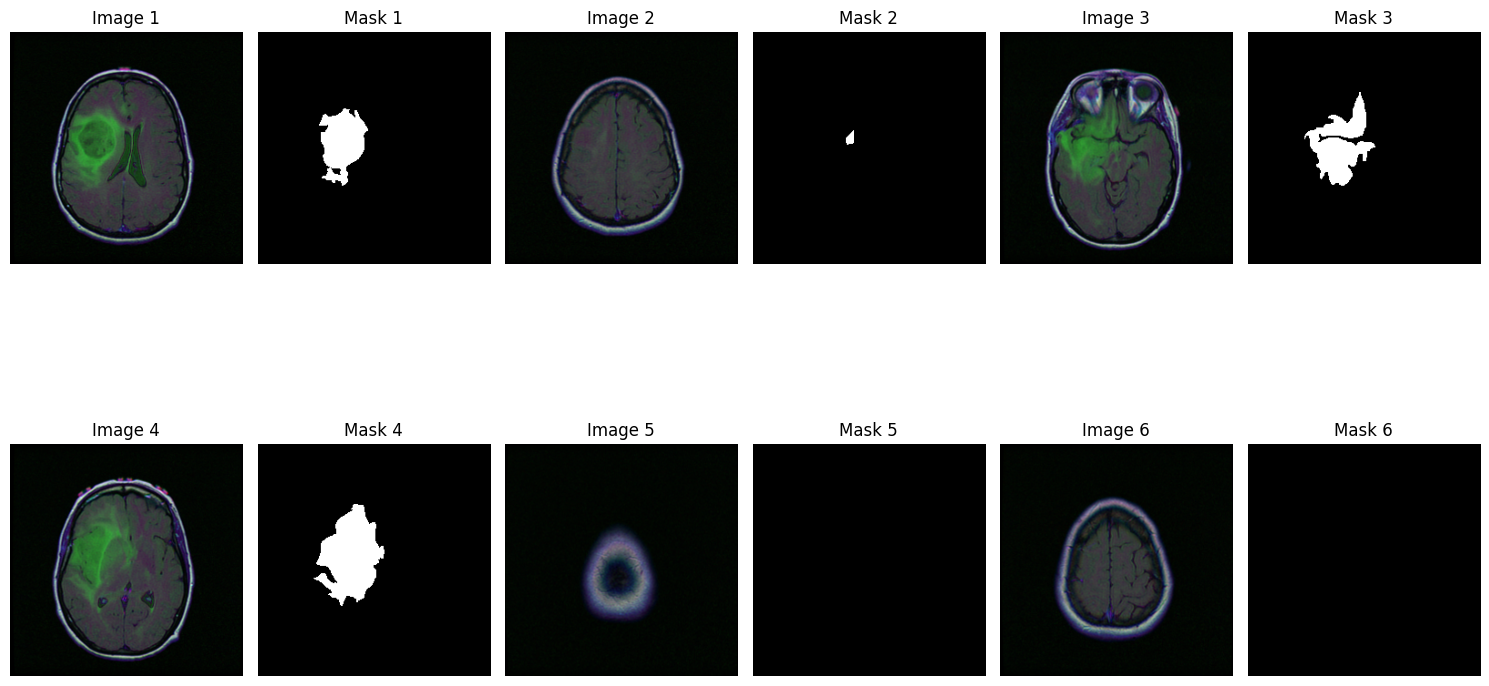

In [ ]:
plot_images_and_masks(2, 3, image_filenames_train, mask_files)

In [ ]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)


(2828, 2)
(393, 2)
(708, 2)


In [ ]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):

    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [ ]:
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [ ]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))

test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))



In [ ]:
gen_sample = next(train_gen)
print(f"Image batch shape: {gen_sample[0].shape}")
print(f"Mask batch shape: {gen_sample[1].shape}")


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Image batch shape: (32, 256, 256, 3)
Mask batch shape: (32, 256, 256, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Dropout,
    Lambda,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    concatenate,
)
from tensorflow.keras import backend as K


def unet(input_size=(256, 256, 3)):

    inputs = Input(input_size)

    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    up6 = concatenate(
        [
            Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn5
            ),
            conv4,
        ],
        axis=3,
    )

    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [
            Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn6
            ),
            conv3,
        ],
        axis=3,
    )
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [
            Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn7
            ),
            conv2,
        ],
        axis=3,
    )
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate(
        [
            Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn8
            ),
            conv1,
        ],
        axis=3,
    )
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])


In [ ]:
def dice_coefficients(y_true, y_pred, smooth=100):

    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)


def dice_coefficients_loss(y_true, y_pred, smooth=100):

    return 1 - dice_coefficients(y_true, y_pred, smooth)


def iou(y_true, y_pred, smooth=100):

    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou



In [ ]:
model = unet(input_size=(im_height, im_width, 3))
print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 64, 64, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

None


In [ ]:
class DebugCallback(tf.keras.callbacks.Callback):
    def on_train_batch_start(self, batch, logs=None):
        print(f"Training batch {batch} started.")

    def on_train_batch_end(self, batch, logs=None):
        print(f"Training batch {batch} ended. Logs: {logs}")


In [ ]:
# import gdown

# # File ID from your link
# file_id = "1-6Iy6z4J_P8jm-DDI1wjGrP"
# # Destination path in your Google Drive
# destination = "/content/drive/My Drive/unet60.weights.h5"

# # Download and save to Google Drive
# gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)


In [ ]:
decay_rate = learning_rate / 200

opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, decay=decay_rate, amsgrad=False)

model.load_weights('/content/drive/My Drive/unet90.weights.h5')

# Compile the model
model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [
    ModelCheckpoint('unet.keras', verbose=1, save_best_only=True),
    DebugCallback()
]

# Validate data generators
train_batch = next(iter(train_gen))
test_batch = next(iter(test_gen))
print(f"Train batch shapes: {train_batch[0].shape}, {train_batch[1].shape}")
print(f"Test batch shapes: {test_batch[0].shape}, {test_batch[1].shape}")



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Found 708 validated image filenames.
Found 708 validated image filenames.
Train batch shapes: (32, 256, 256, 3), (32, 256, 256, 1)
Test batch shapes: (32, 256, 256, 3), (32, 256, 256, 1)


In [ ]:
# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=int(len(df_train) / BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=test_gen,
    validation_steps=int(len(df_val) / BATCH_SIZE)
)

In [ ]:
# Save weights to Google Drive
model.save_weights('/content/drive/My Drive/unet_E100.weights.h5')

In [ ]:
# Select a specific test image
test_image = df_test.iloc[1]['image_filenames_train']  # Example: first image in test set
true_mask = df_test.iloc[1]['mask']  # Ground truth mask

# Load the image and preprocess it for the model
from tensorflow.keras.utils import load_img, img_to_array

img = load_img(test_image, target_size=(im_height, im_width))  # Resize image
img_array = img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the mask
predicted_mask = model.predict(img_array)
predicted_mask = (predicted_mask > 0.5).astype(np.float32)  # Thresholding to binary mask


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
# Resize true mask to match predicted mask dimensions
true_mask_resized = load_img(true_mask, target_size=(im_height, im_width), color_mode='grayscale')
true_mask_array = img_to_array(true_mask_resized) / 255.0
true_mask_array = (true_mask_array > 0.5).astype(np.float32)

# Compute metrics
dice = dice_coefficients(true_mask_array, predicted_mask[1])
iou = iou(true_mask_array, predicted_mask[1])

print(f"Dice Coefficient: {dice:.4f}")
print(f"IoU Score: {iou:.4f}")


IndexError: index 1 is out of bounds for axis 0 with size 1

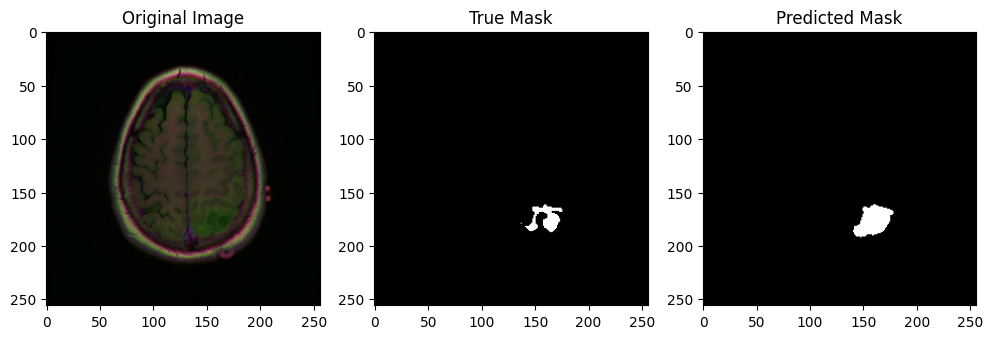

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(true_mask_array.squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask[0].squeeze(), cmap='gray')

plt.show()
